In [1]:
from keras import layers, models, optimizers
from keras import datasets
from keras import backend as K
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import sys

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

print('Python version : ', sys.version)
print('TensorFlow version : ', tf.__version__)
print('Keras version : ', keras.__version__)
    
K.set_image_data_format('channels_first')
print(K.image_data_format())

Using TensorFlow backend.


Python version :  3.6.8 |Anaconda, Inc.| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]
TensorFlow version :  1.14.0
Keras version :  2.0.0
channels_first


In [2]:
class GAN(models.Sequential):
    def __init__(self, input_dim):
        super().__init__()

        self.input_dim = input_dim

        self.generator = self.make_G()
        self.discriminator = self.make_D()

        self.add(self.generator)
        self.discriminator.trainable = False
        self.add(self.discriminator)

        self.compile_all()

    def make_G(self):
        input_dim = self.input_dim

        model = models.Sequential()
        model.add(layers.Dense(1024, activation='tanh', input_dim=input_dim))
        model.add(layers.Dense(128 * 7 * 7, activation='tanh'))
        model.add(layers.BatchNormalization())
        model.add(layers.Reshape((128, 7, 7), input_shape=(128 * 7 * 7,)))
        model.add(layers.UpSampling2D(size=(2, 2)))
        model.add(layers.Conv2D(64, (5, 5), padding='same', activation='tanh'))
        model.add(layers.UpSampling2D(size=(2, 2)))
        model.add(layers.Conv2D(1, (5, 5), padding='same', activation='tanh'))
        return model

    def make_D(self):
        model = models.Sequential()
        model.add(layers.Conv2D(64, (5, 5), padding='same', activation='tanh',
                               input_shape=(1, 28, 28)))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Conv2D(128, (5, 5), padding='same', activation='tanh'))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Flatten())
        model.add(layers.Dense(1024, activation='tanh'))
        model.add(layers.Dense(1, activation='sigmoid'))
        return model

    def compile_all(self):
        opt_D = optimizers.SGD(lr=0.0005, momentum=0.9, nesterov=True)
        opt_G = optimizers.SGD(lr=0.0005, momentum=0.9, nesterov=True)

        self.compile(loss='binary_crossentropy', optimizer=opt_G)

        self.discriminator.trainable = True
        self.discriminator.compile(loss='binary_crossentropy', optimizer=opt_D)

    def get_z(self, ln):
        return np.random.uniform(-1.0, 1.0, (ln, self.input_dim))
    
    def train_once(self, x):
        ln = x.shape[0]

        z = self.get_z(ln)
        gen = self.generator.predict(z, verbose=0)
        input_D = np.concatenate((x, gen))
        y_D = [1] * ln + [0] * ln
        loss_D = self.discriminator.train_on_batch(input_D, y_D)

        z = self.get_z(ln)
        self.discriminator.trainable = False
        loss_G = self.train_on_batch(z, [1] * ln)
        self.discriminator.trainable = True

        return loss_D, loss_G

In [3]:
def get_x(x_train, index, batch_size):
        return x_train[index * batch_size:(index + 1) * batch_size]

In [4]:
class MnistData():
    def __init__(self):
        (x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

        img_rows, img_cols = x_train.shape[1:]

        x_train = x_train.astype('float32') - 127.5
        x_test = x_test.astype('float32') - 127.5
        x_train /= 127.5
        x_test /= 127.5
        
        self.num_classes = 10
        self.x_train, self.y_train = x_train, y_train
        self.x_test, self.y_test = x_test, y_test

In [5]:
def main():
    batch_size = 100
    epochs = 200
    input_dim = 100
    sample_size = 6

    data = MnistData()
    x_train = data.x_train
    x_train = x_train.reshape((x_train.shape[0], 1) + x_train.shape[1:])

    gan = GAN(input_dim)

    for epoch in range(epochs):
        print("Epoch", epoch)
    
        for index in range(int(x_train.shape[0] / batch_size)):
            x = get_x(x_train, index, batch_size)
            loss_D, loss_G = gan.train_once(x)

        print('Loss D:', loss_D)
        print('Loss G:', loss_G)

        if epoch % 2 == 0 or epoch == epochs - 1:
            z = gan.get_z(sample_size)
            gen = gan.generator.predict(z, verbose=0)

            plt.figure(figsize=(20, 2))

            for i in range(sample_size):
                ax = plt.subplot(1, sample_size, i + 1)
                plt.imshow(gen[i].reshape((28, 28)))
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
            plt.show()

W0110 14:57:35.785600 18160 deprecation_wrapper.py:119] From C:\Users\soohyun\Anaconda3\envs\jinho\lib\site-packages\keras\backend\tensorflow_backend.py:47: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0110 14:57:35.796600 18160 deprecation_wrapper.py:119] From C:\Users\soohyun\Anaconda3\envs\jinho\lib\site-packages\keras\backend\tensorflow_backend.py:349: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0110 14:57:35.797600 18160 deprecation_wrapper.py:119] From C:\Users\soohyun\Anaconda3\envs\jinho\lib\site-packages\keras\backend\tensorflow_backend.py:3147: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0110 14:57:35.864600 18160 deprecation_wrapper.py:119] From C:\Users\soohyun\Anaconda3\envs\jinho\lib\site-packages\keras\backend\tensorflow_backend.py:1578: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_ne

Epoch 0


W0110 14:57:36.444600 18160 deprecation.py:506] From C:\Users\soohyun\Anaconda3\envs\jinho\lib\site-packages\keras\backend\tensorflow_backend.py:519: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Loss D: 0.6862178
Loss G: 0.9194039


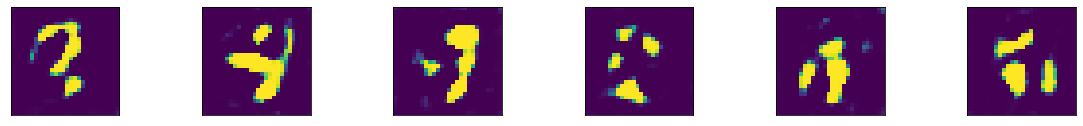

Epoch 1
Loss D: 0.50683874
Loss G: 0.95984113
Epoch 2
Loss D: 0.6330019
Loss G: 3.251232


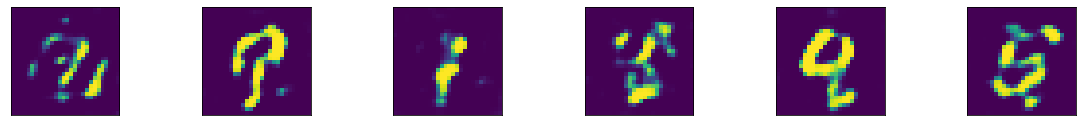

Epoch 3
Loss D: 0.31205106
Loss G: 2.024489
Epoch 4
Loss D: 0.44020474
Loss G: 2.170019


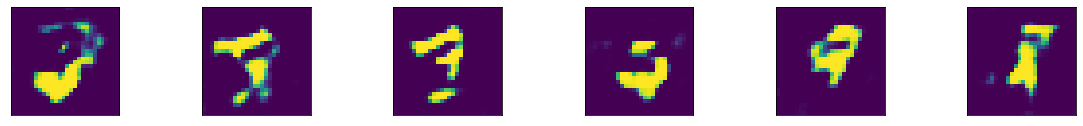

Epoch 5
Loss D: 0.25620422
Loss G: 2.2066066
Epoch 6
Loss D: 0.2916539
Loss G: 2.7338736


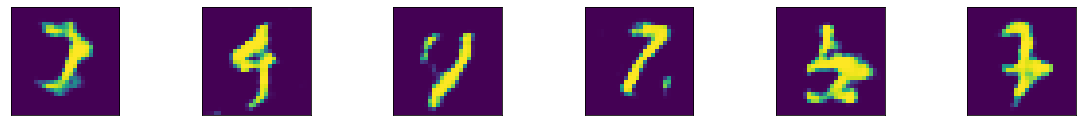

Epoch 7
Loss D: 0.2883772
Loss G: 2.2602763
Epoch 8
Loss D: 0.23943268
Loss G: 2.338646


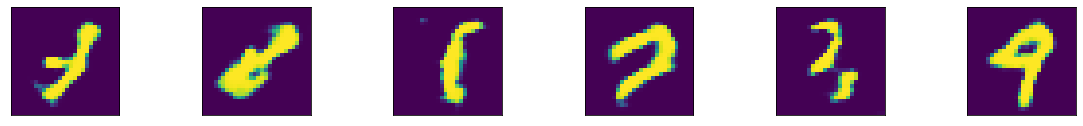

Epoch 9
Loss D: 0.34428185
Loss G: 2.712607
Epoch 10
Loss D: 0.6433966
Loss G: 1.2397557


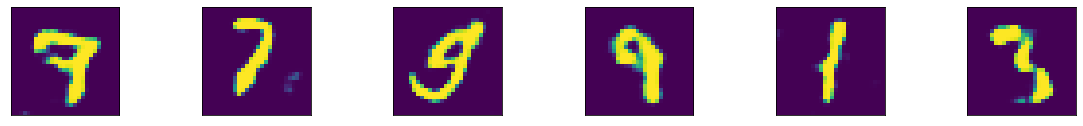

Epoch 11
Loss D: 0.4938597
Loss G: 0.8292364
Epoch 12
Loss D: 0.3249811
Loss G: 2.6593375


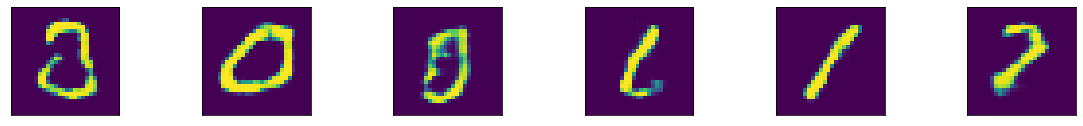

Epoch 13
Loss D: 0.4292893
Loss G: 4.080023
Epoch 14
Loss D: 0.3890708
Loss G: 1.2813665


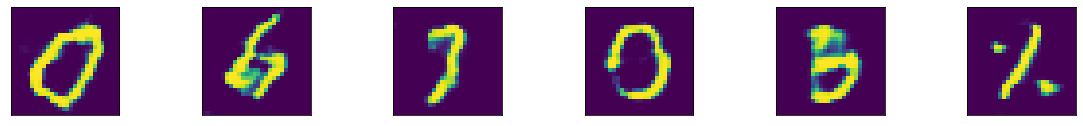

Epoch 15
Loss D: 0.30886197
Loss G: 1.5668393
Epoch 16
Loss D: 0.3929273
Loss G: 1.2918946


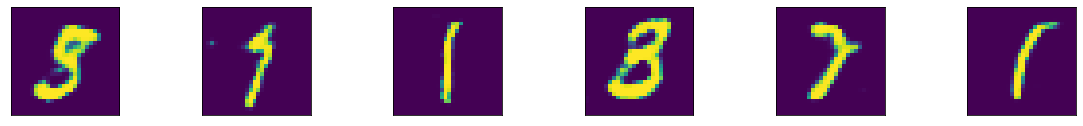

Epoch 17
Loss D: 0.3097025
Loss G: 3.5777686
Epoch 18
Loss D: 0.2231051
Loss G: 2.712569


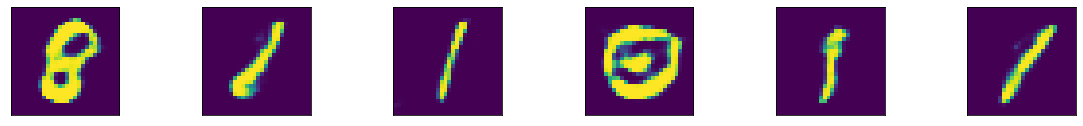

Epoch 19
Loss D: 0.30180177
Loss G: 2.0895624
Epoch 20
Loss D: 0.25944275
Loss G: 2.6648197


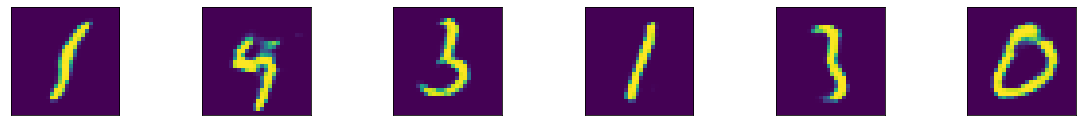

Epoch 21
Loss D: 0.23607083
Loss G: 3.1669495
Epoch 22
Loss D: 0.31992644
Loss G: 2.6486392


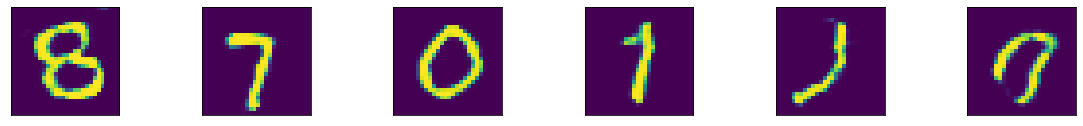

Epoch 23
Loss D: 0.27002198
Loss G: 1.9049714
Epoch 24
Loss D: 0.30697015
Loss G: 2.4552882


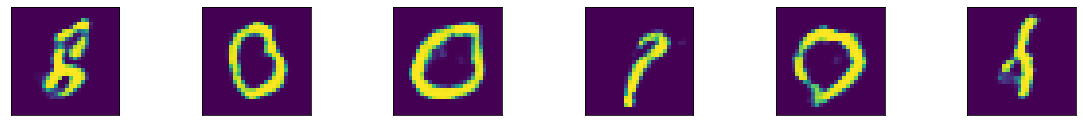

Epoch 25
Loss D: 0.32288685
Loss G: 2.9180996
Epoch 26
Loss D: 0.13549574
Loss G: 3.5193365


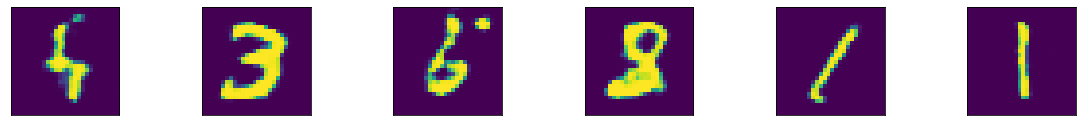

Epoch 27
Loss D: 0.22800498
Loss G: 2.0478196
Epoch 28
Loss D: 0.28387487
Loss G: 3.1761248


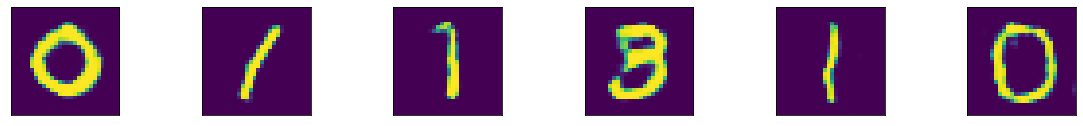

Epoch 29
Loss D: 0.29088274
Loss G: 3.4760582
Epoch 30
Loss D: 0.33602402
Loss G: 3.1320128


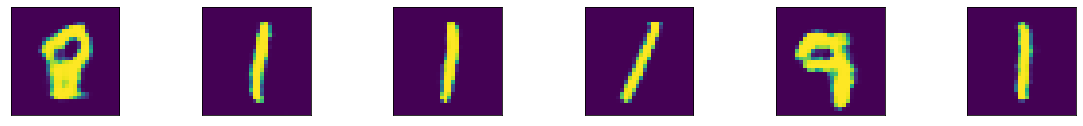

Epoch 31
Loss D: 0.20264347
Loss G: 3.0049121
Epoch 32
Loss D: 0.29349902
Loss G: 2.8904617


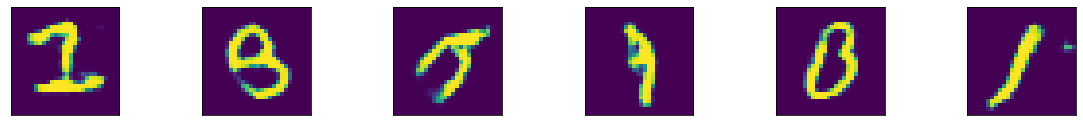

Epoch 33
Loss D: 0.25204927
Loss G: 3.1049345
Epoch 34
Loss D: 0.2507075
Loss G: 2.580898


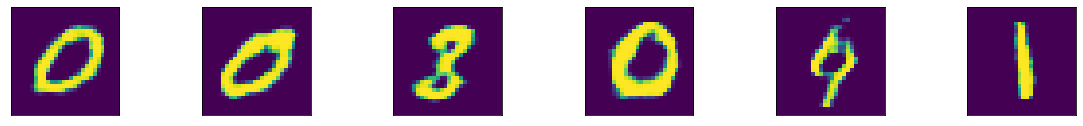

Epoch 35
Loss D: 0.21434654
Loss G: 2.1315305
Epoch 36
Loss D: 0.23814209
Loss G: 2.6749563


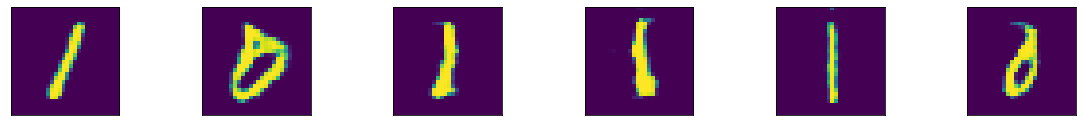

Epoch 37
Loss D: 0.26736087
Loss G: 2.632241
Epoch 38
Loss D: 0.24800235
Loss G: 2.382625


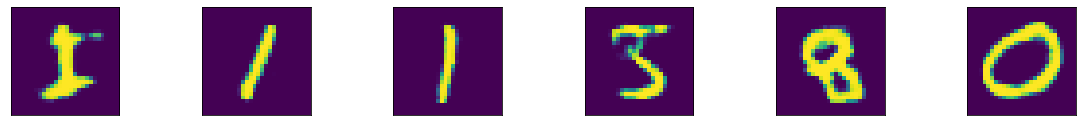

Epoch 39
Loss D: 0.25227046
Loss G: 2.6135778
Epoch 40
Loss D: 0.28853974
Loss G: 2.9026368


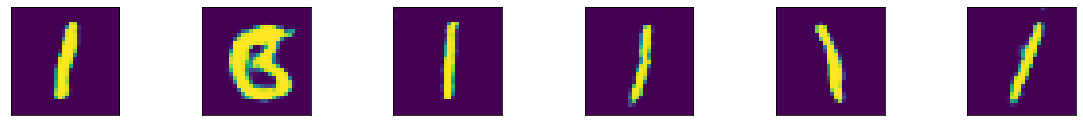

Epoch 41
Loss D: 0.24029514
Loss G: 3.0258973
Epoch 42
Loss D: 0.24288303
Loss G: 2.5274153


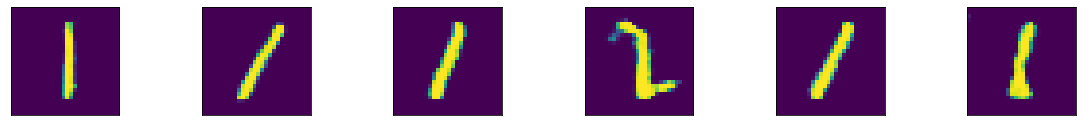

Epoch 43
Loss D: 0.23758034
Loss G: 2.57988
Epoch 44
Loss D: 0.2649492
Loss G: 2.1855297


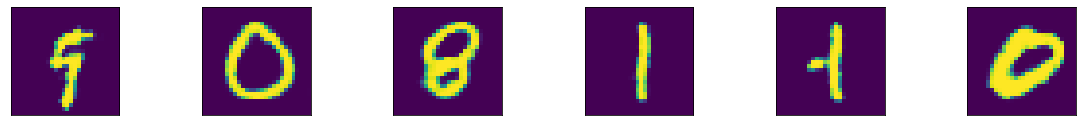

Epoch 45
Loss D: 0.24405865
Loss G: 2.1060665
Epoch 46
Loss D: 0.20561323
Loss G: 2.50131


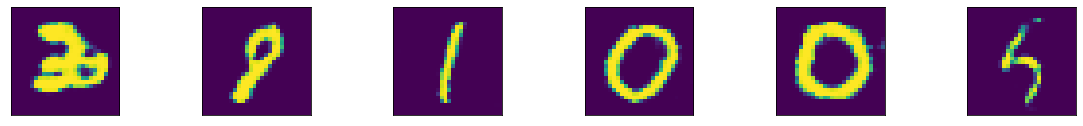

Epoch 47
Loss D: 0.23062581
Loss G: 2.586308
Epoch 48
Loss D: 0.21927035
Loss G: 2.5061219


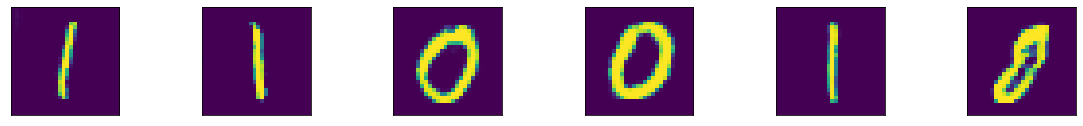

Epoch 49
Loss D: 0.19269298
Loss G: 2.3403444
Epoch 50
Loss D: 0.20776798
Loss G: 2.1433628


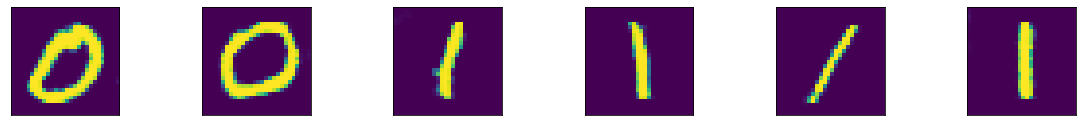

Epoch 51
Loss D: 0.1905154
Loss G: 2.3678262
Epoch 52
Loss D: 0.23346838
Loss G: 3.0422773


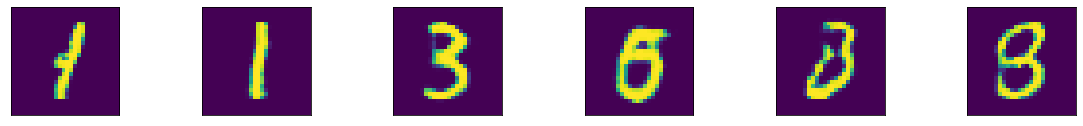

Epoch 53
Loss D: 0.21547261
Loss G: 2.0287507
Epoch 54
Loss D: 0.19853233
Loss G: 2.1594634


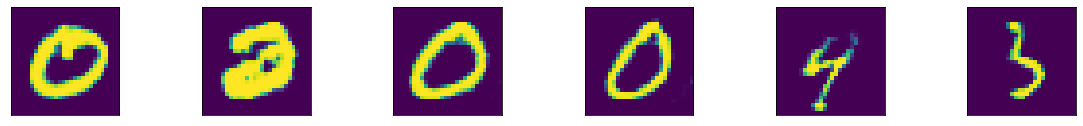

Epoch 55
Loss D: 0.19037832
Loss G: 2.4383361
Epoch 56
Loss D: 0.26960015
Loss G: 2.9296217


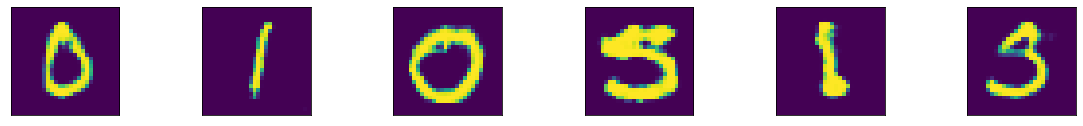

Epoch 57
Loss D: 0.20123146
Loss G: 2.6905255
Epoch 58
Loss D: 0.19847684
Loss G: 2.6554666


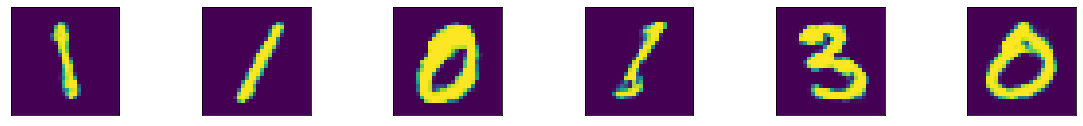

Epoch 59
Loss D: 0.19680843
Loss G: 2.586468
Epoch 60
Loss D: 0.23213884
Loss G: 2.6569898


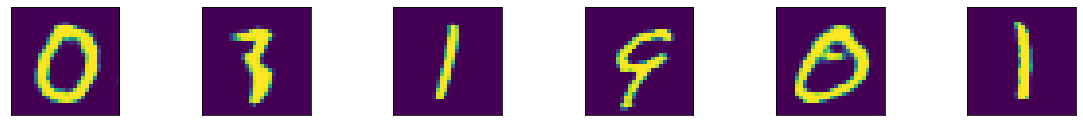

Epoch 61
Loss D: 0.21355583
Loss G: 2.588006
Epoch 62
Loss D: 0.18432075
Loss G: 2.556916


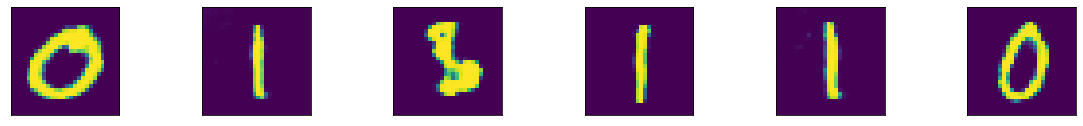

Epoch 63
Loss D: 0.196712
Loss G: 2.2582502
Epoch 64
Loss D: 0.18161067
Loss G: 2.5337276


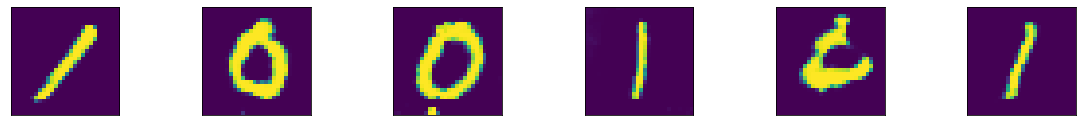

Epoch 65
Loss D: 0.18816008
Loss G: 2.665152
Epoch 66
Loss D: 0.17243424
Loss G: 2.380101


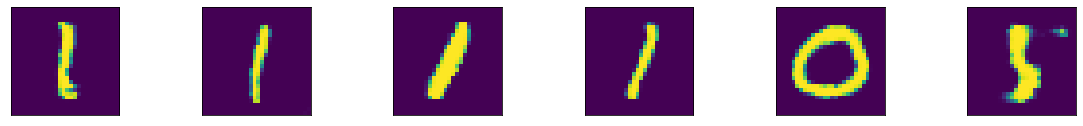

Epoch 67
Loss D: 0.22132307
Loss G: 2.9972723
Epoch 68
Loss D: 0.16706657
Loss G: 2.780025


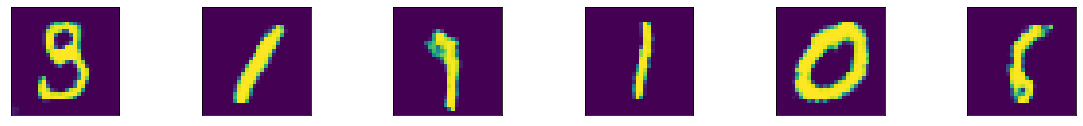

Epoch 69
Loss D: 0.25130746
Loss G: 3.0073855
Epoch 70
Loss D: 0.23258446
Loss G: 3.0259018


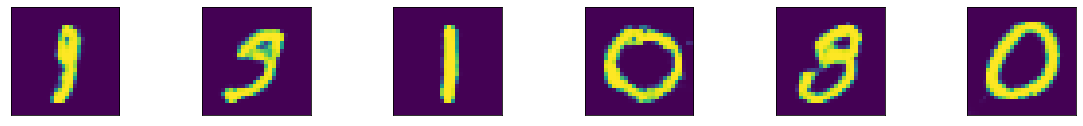

Epoch 71
Loss D: 0.17889541
Loss G: 2.5307145
Epoch 72
Loss D: 0.21868962
Loss G: 2.841645


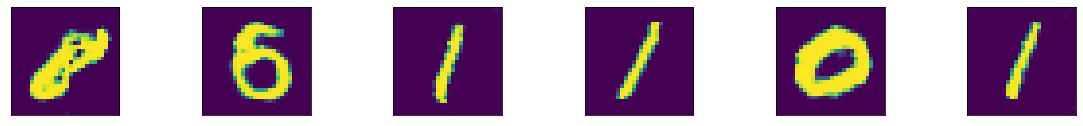

Epoch 73
Loss D: 0.17829658
Loss G: 2.487316
Epoch 74
Loss D: 0.23260084
Loss G: 3.0632653


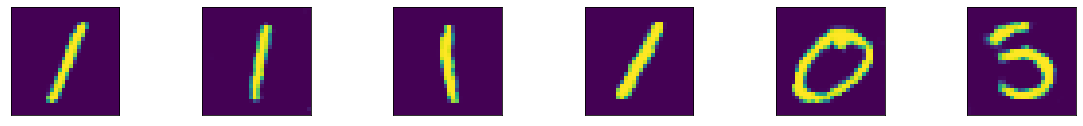

Epoch 75
Loss D: 0.19905213
Loss G: 2.6585388
Epoch 76
Loss D: 0.22859581
Loss G: 2.7268698


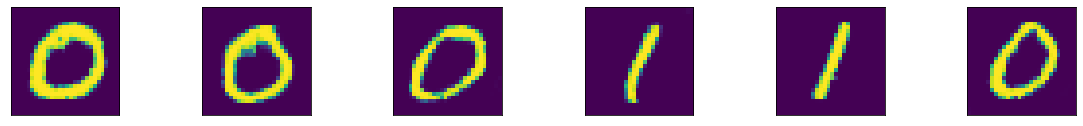

Epoch 77
Loss D: 0.1961691
Loss G: 2.9557688
Epoch 78
Loss D: 0.20898479
Loss G: 2.7812238


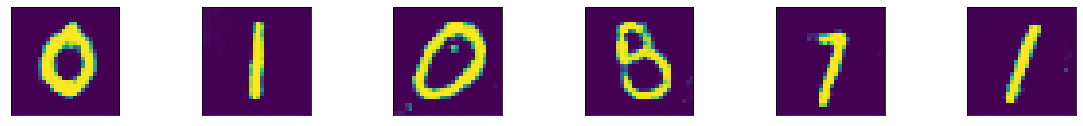

Epoch 79
Loss D: 0.18671936
Loss G: 2.7454026
Epoch 80
Loss D: 0.19891578
Loss G: 2.191535


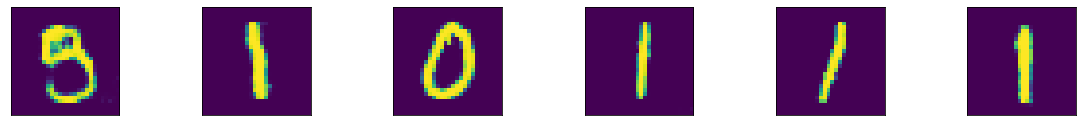

Epoch 81
Loss D: 0.19164619
Loss G: 2.6606922
Epoch 82
Loss D: 0.15804228
Loss G: 2.9206414


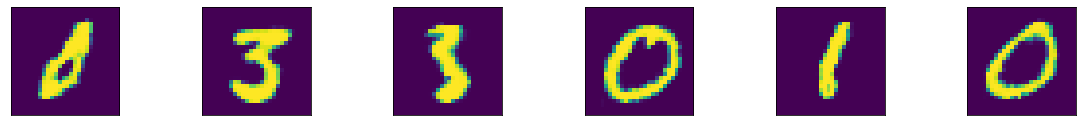

Epoch 83
Loss D: 0.1911683
Loss G: 2.6409335
Epoch 84
Loss D: 0.22468409
Loss G: 3.4713526


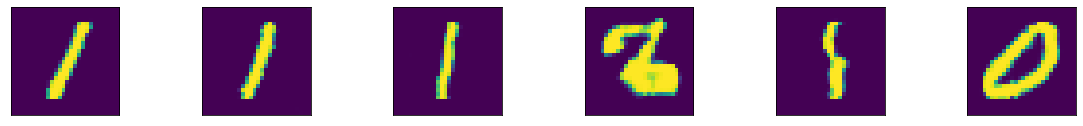

Epoch 85
Loss D: 0.17918403
Loss G: 2.8493989
Epoch 86
Loss D: 0.18091351
Loss G: 3.0801325


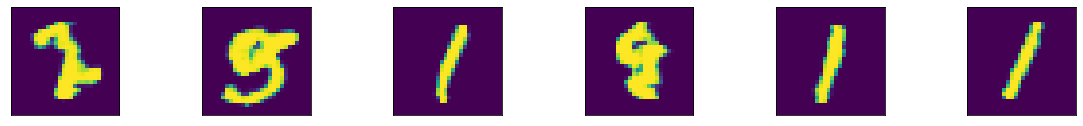

Epoch 87
Loss D: 0.17493206
Loss G: 2.4321992
Epoch 88
Loss D: 0.19626503
Loss G: 2.6297626


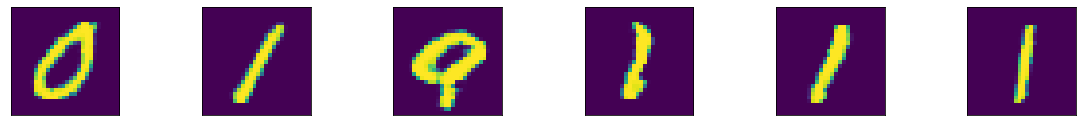

Epoch 89
Loss D: 0.17385131
Loss G: 2.6697462
Epoch 90
Loss D: 0.20670666
Loss G: 2.944711


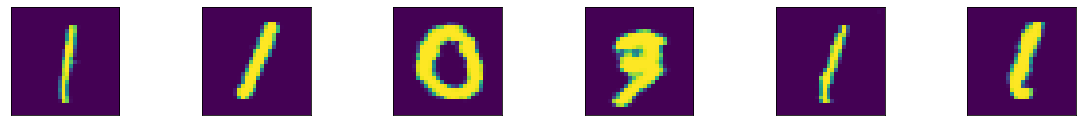

Epoch 91
Loss D: 0.17881331
Loss G: 2.471289
Epoch 92
Loss D: 0.18588513
Loss G: 2.4183471


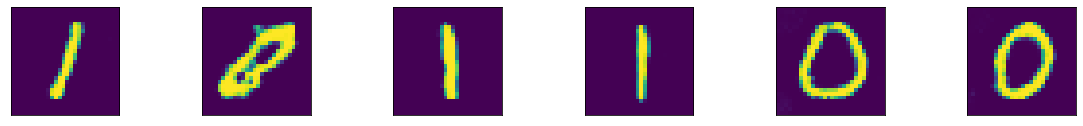

Epoch 93
Loss D: 0.15535398
Loss G: 2.6420765
Epoch 94
Loss D: 0.19559889
Loss G: 2.468368


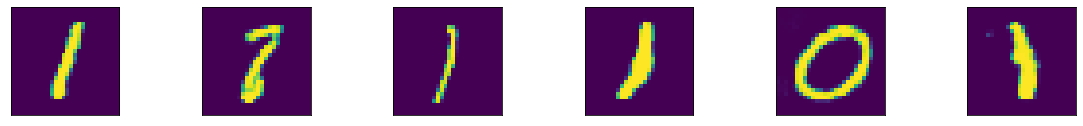

Epoch 95
Loss D: 0.1783072
Loss G: 2.5335767
Epoch 96
Loss D: 0.16525196
Loss G: 2.784399


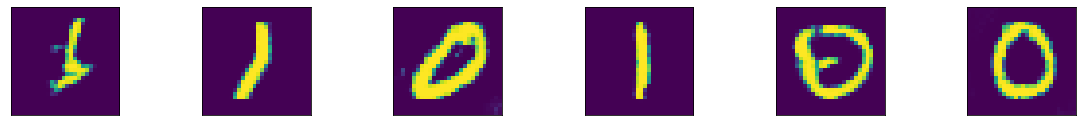

Epoch 97
Loss D: 0.15972167
Loss G: 2.6799698
Epoch 98
Loss D: 0.15613571
Loss G: 2.770475


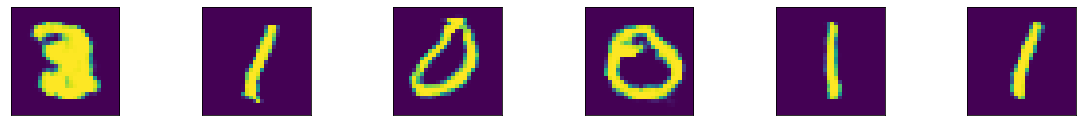

Epoch 99
Loss D: 0.17041813
Loss G: 2.7817903
Epoch 100
Loss D: 0.20025401
Loss G: 2.6203659


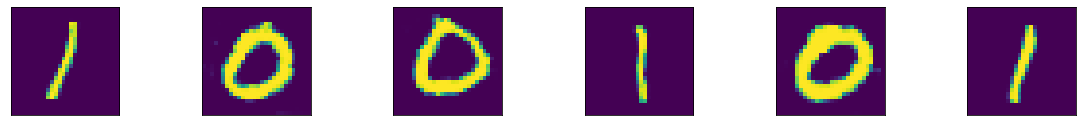

Epoch 101
Loss D: 0.15963672
Loss G: 2.7383533
Epoch 102
Loss D: 0.18243665
Loss G: 2.4125717


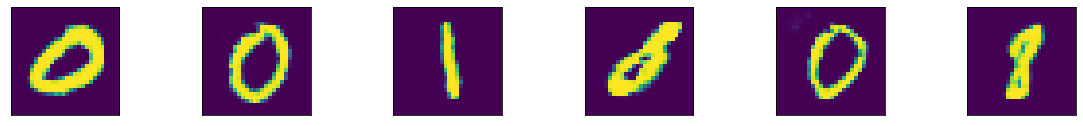

Epoch 103
Loss D: 0.17067337
Loss G: 2.4271457
Epoch 104
Loss D: 0.14834127
Loss G: 2.8200238


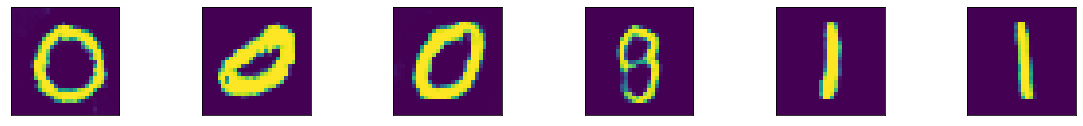

Epoch 105
Loss D: 0.21298873
Loss G: 2.4730773
Epoch 106
Loss D: 0.18756622
Loss G: 2.503662


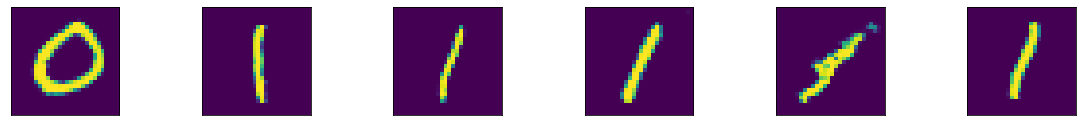

Epoch 107
Loss D: 0.18627876
Loss G: 2.2488468
Epoch 108
Loss D: 0.2000187
Loss G: 2.6955497


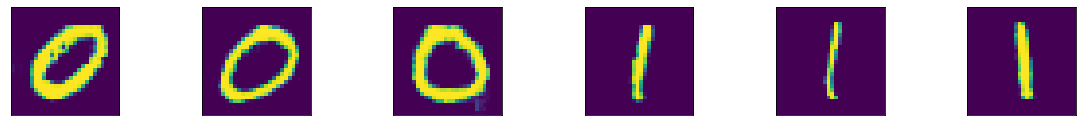

Epoch 109
Loss D: 0.17509209
Loss G: 2.7886646
Epoch 110
Loss D: 0.21727407
Loss G: 2.899716


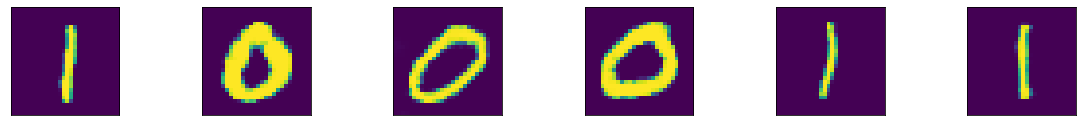

Epoch 111
Loss D: 0.16887462
Loss G: 2.2204309
Epoch 112
Loss D: 0.16196471
Loss G: 2.4190881


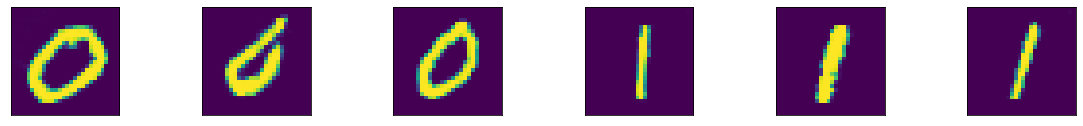

Epoch 113
Loss D: 0.17072399
Loss G: 2.926906
Epoch 114
Loss D: 0.15828128
Loss G: 2.4310813


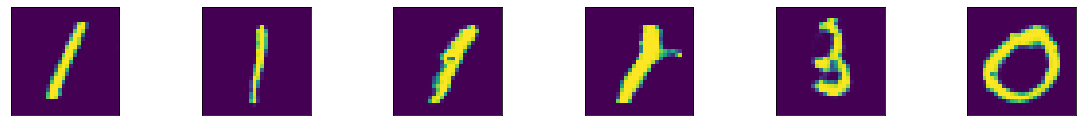

Epoch 115
Loss D: 0.17365801
Loss G: 2.347478
Epoch 116
Loss D: 0.18046467
Loss G: 2.3453207


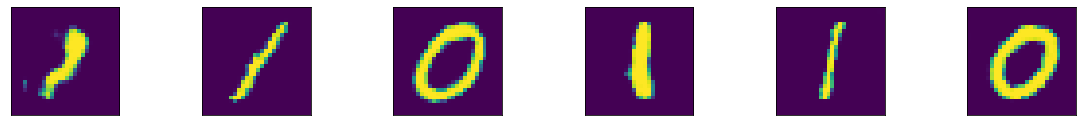

Epoch 117
Loss D: 0.1826746
Loss G: 2.2384639
Epoch 118
Loss D: 0.1767544
Loss G: 2.605907


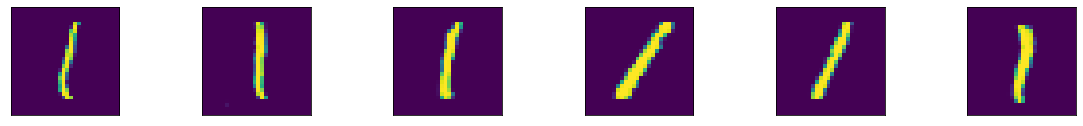

Epoch 119
Loss D: 0.14799008
Loss G: 2.666728
Epoch 120
Loss D: 0.21219037
Loss G: 2.6644862


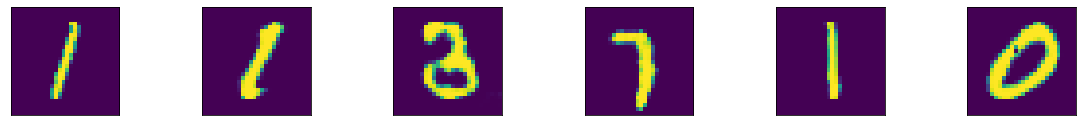

Epoch 121
Loss D: 0.18594816
Loss G: 2.653396
Epoch 122
Loss D: 0.1578288
Loss G: 2.566065


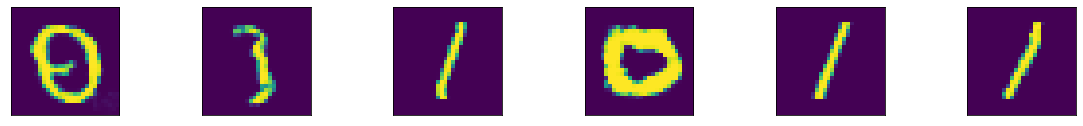

Epoch 123
Loss D: 0.18926716
Loss G: 2.473165
Epoch 124
Loss D: 0.1915263
Loss G: 2.5753503


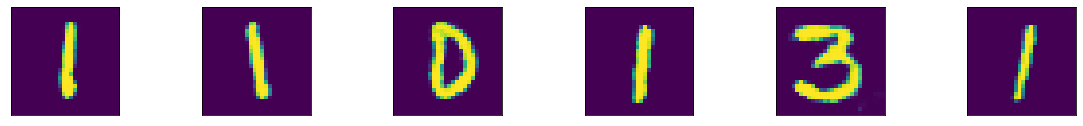

Epoch 125
Loss D: 0.18332231
Loss G: 2.9587493
Epoch 126
Loss D: 0.14036143
Loss G: 2.5634108


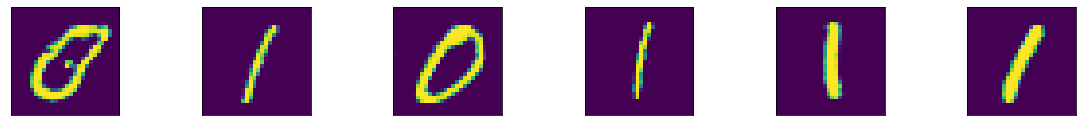

Epoch 127
Loss D: 0.14350028
Loss G: 2.704774
Epoch 128
Loss D: 0.1634118
Loss G: 2.759556


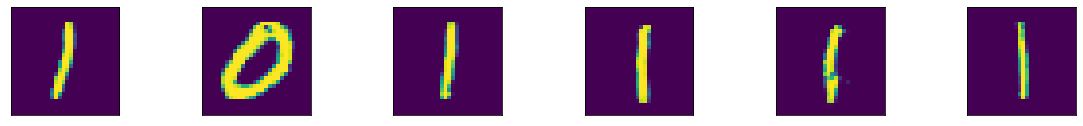

Epoch 129
Loss D: 0.17041963
Loss G: 2.448654
Epoch 130
Loss D: 0.1494623
Loss G: 2.4229543


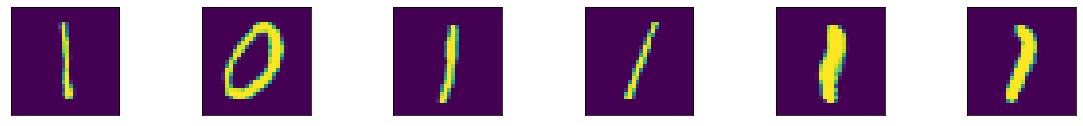

Epoch 131
Loss D: 0.154357
Loss G: 3.0235145
Epoch 132
Loss D: 0.17244586
Loss G: 2.42865


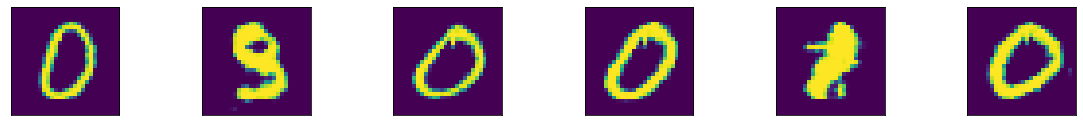

Epoch 133
Loss D: 0.20541942
Loss G: 2.8572776
Epoch 134
Loss D: 0.18045922
Loss G: 2.5834184


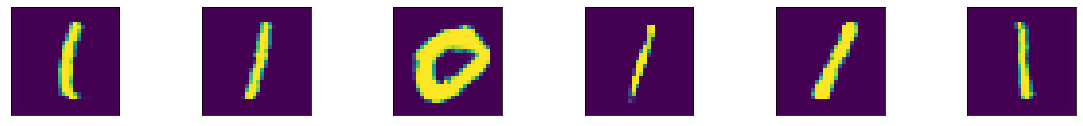

Epoch 135
Loss D: 0.16767827
Loss G: 2.7456636
Epoch 136
Loss D: 0.1477683
Loss G: 2.8047533


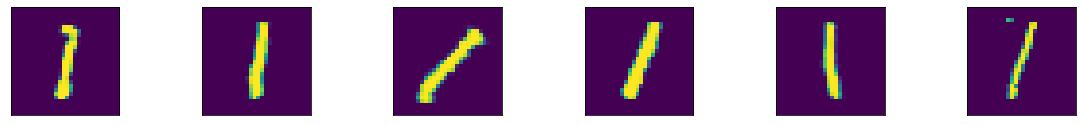

Epoch 137
Loss D: 0.17045754
Loss G: 2.8365374
Epoch 138
Loss D: 0.16455778
Loss G: 2.8400283


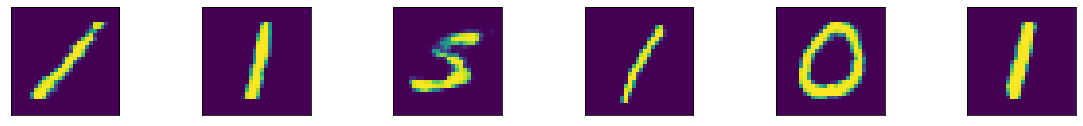

Epoch 139
Loss D: 0.16440475
Loss G: 2.6628733
Epoch 140
Loss D: 0.17042795
Loss G: 2.7090147


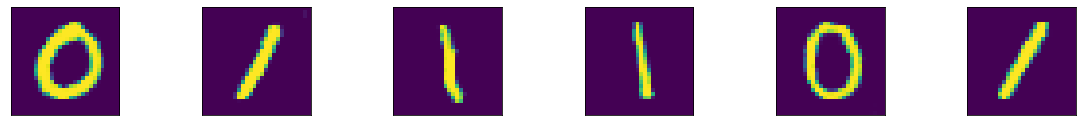

Epoch 141
Loss D: 0.14763905
Loss G: 2.6482162
Epoch 142
Loss D: 0.15947095
Loss G: 2.8021674


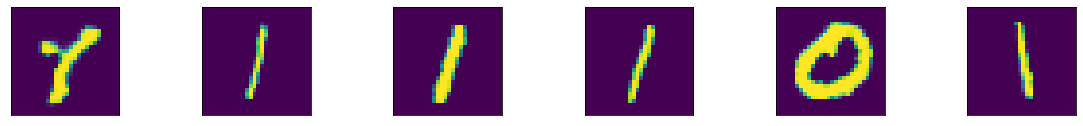

Epoch 143
Loss D: 0.15647312
Loss G: 2.698829
Epoch 144
Loss D: 0.12950228
Loss G: 2.306133


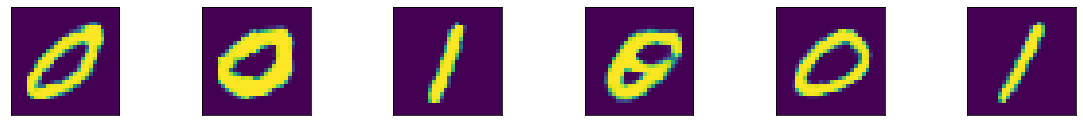

Epoch 145
Loss D: 0.18661492
Loss G: 2.3844824
Epoch 146
Loss D: 0.15902705
Loss G: 2.897812


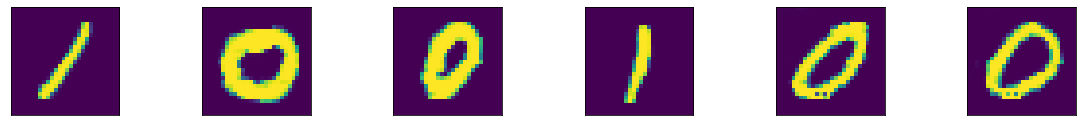

Epoch 147
Loss D: 0.1593183
Loss G: 2.5660923
Epoch 148
Loss D: 0.14493382
Loss G: 2.5456657


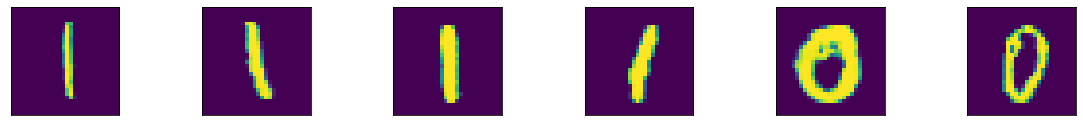

Epoch 149
Loss D: 0.16442603
Loss G: 2.1405544
Epoch 150
Loss D: 0.19439846
Loss G: 2.3763838


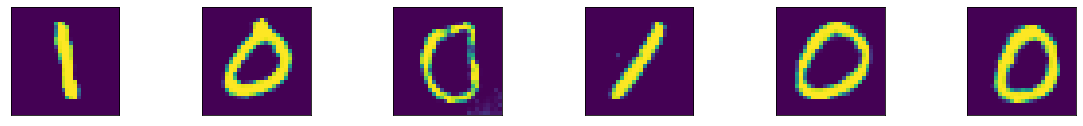

Epoch 151
Loss D: 0.16254768
Loss G: 2.63293
Epoch 152
Loss D: 0.1908848
Loss G: 2.3135598


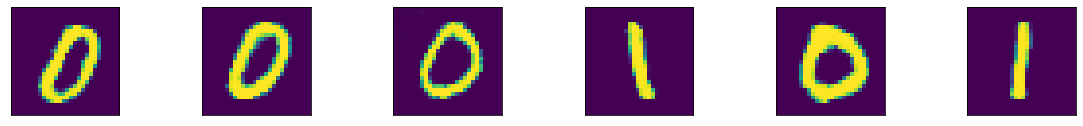

Epoch 153
Loss D: 0.1905841
Loss G: 2.516962
Epoch 154
Loss D: 0.1794025
Loss G: 2.203784


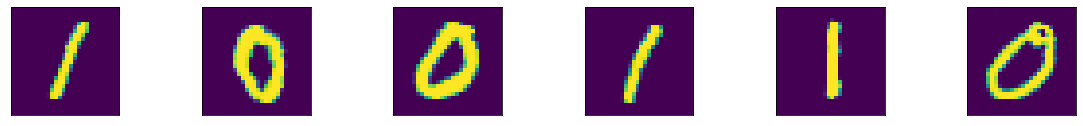

Epoch 155
Loss D: 0.17348887
Loss G: 2.4329095
Epoch 156
Loss D: 0.17013189
Loss G: 2.5254683


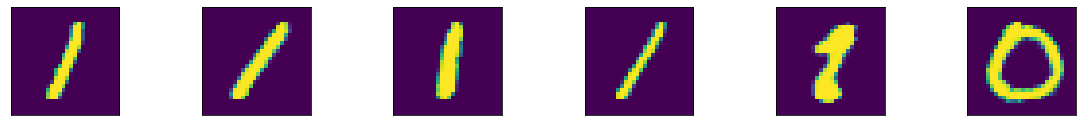

Epoch 157
Loss D: 0.15080269
Loss G: 2.7531698
Epoch 158
Loss D: 0.1638834
Loss G: 2.4878573


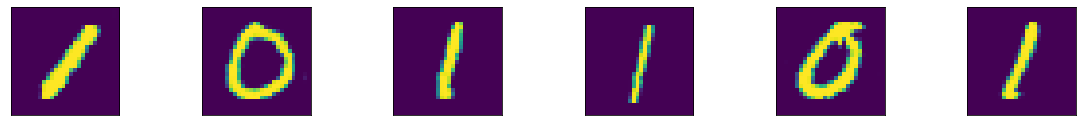

Epoch 159
Loss D: 0.15244895
Loss G: 2.7983136
Epoch 160
Loss D: 0.20782772
Loss G: 2.371763


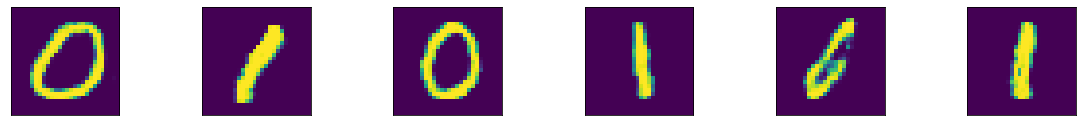

Epoch 161
Loss D: 0.19543102
Loss G: 2.537773
Epoch 162
Loss D: 0.16529594
Loss G: 2.737452


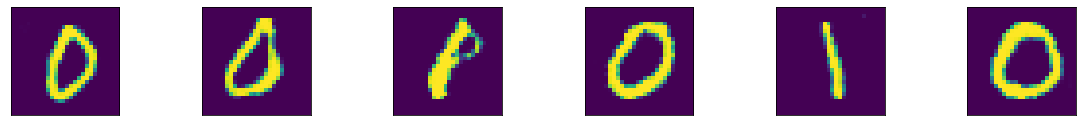

Epoch 163
Loss D: 0.15139595
Loss G: 2.6625893
Epoch 164
Loss D: 0.14876908
Loss G: 2.5881612


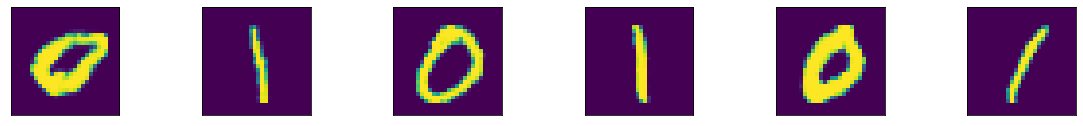

Epoch 165
Loss D: 0.15497786
Loss G: 2.570462
Epoch 166
Loss D: 0.1578469
Loss G: 3.0908217


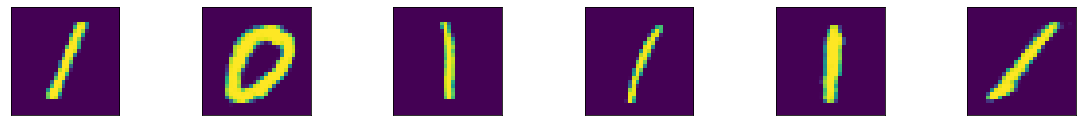

Epoch 167
Loss D: 0.1641539
Loss G: 2.5906565
Epoch 168
Loss D: 0.1638946
Loss G: 2.354075


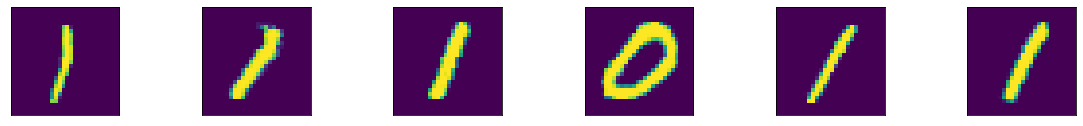

Epoch 169
Loss D: 0.13012265
Loss G: 2.8504899
Epoch 170
Loss D: 0.17762098
Loss G: 2.3219573


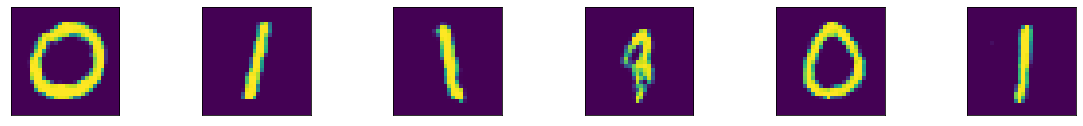

Epoch 171
Loss D: 0.16107625
Loss G: 2.6854677
Epoch 172
Loss D: 0.14734381
Loss G: 2.6647003


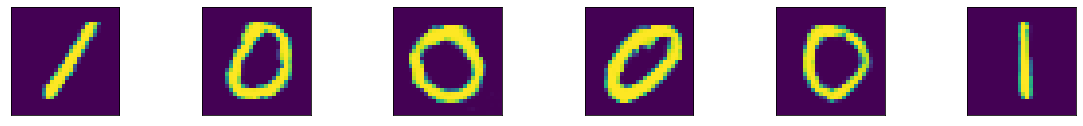

Epoch 173
Loss D: 0.17152219
Loss G: 2.636312
Epoch 174
Loss D: 0.16389397
Loss G: 2.5907905


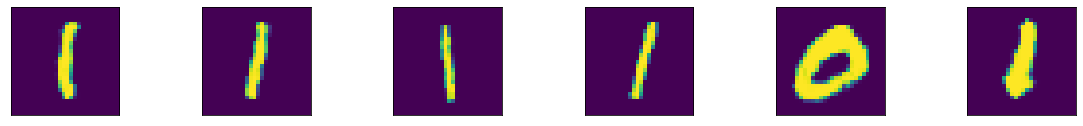

Epoch 175
Loss D: 0.15724392
Loss G: 2.6910949
Epoch 176
Loss D: 0.16803665
Loss G: 2.480649


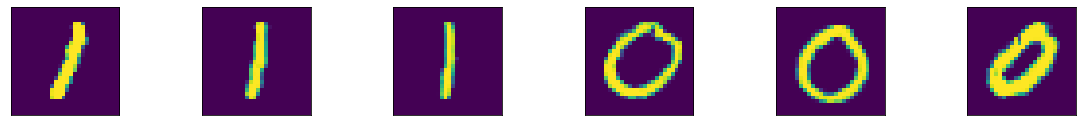

Epoch 177
Loss D: 0.15702705
Loss G: 2.4119465
Epoch 178
Loss D: 0.13586916
Loss G: 2.8450532


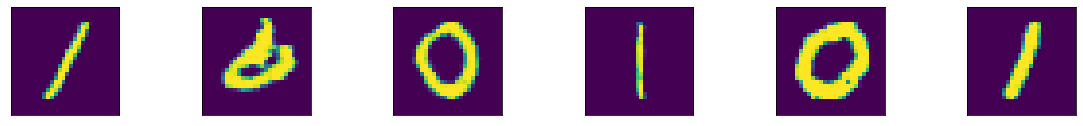

Epoch 179
Loss D: 0.1816394
Loss G: 2.5881355
Epoch 180
Loss D: 0.145153
Loss G: 3.0381973


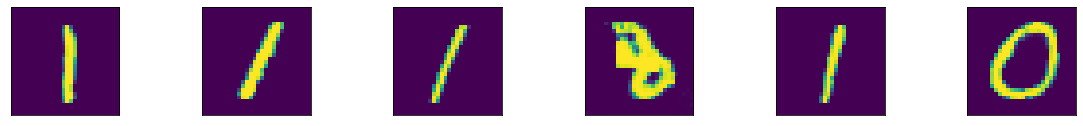

Epoch 181
Loss D: 0.13814838
Loss G: 3.0004284
Epoch 182
Loss D: 0.1454731
Loss G: 2.8659365


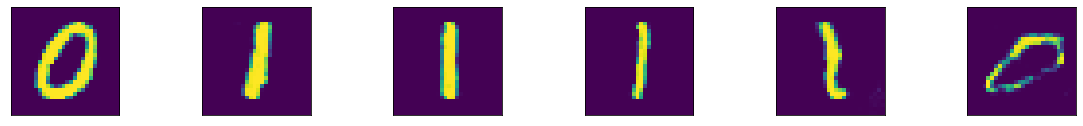

Epoch 183
Loss D: 0.13124566
Loss G: 2.9929602
Epoch 184
Loss D: 0.14756815
Loss G: 2.8926837


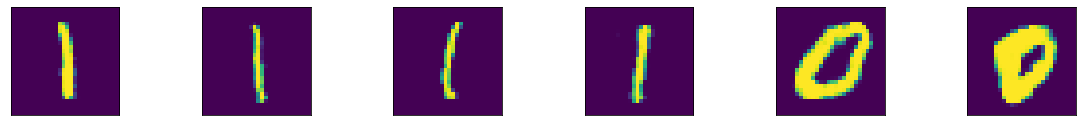

Epoch 185
Loss D: 0.16109127
Loss G: 2.7314258
Epoch 186
Loss D: 0.16188546
Loss G: 2.5883374


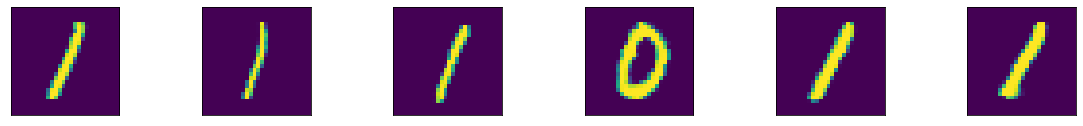

Epoch 187
Loss D: 0.17208225
Loss G: 3.06484
Epoch 188
Loss D: 0.13884592
Loss G: 3.2107325


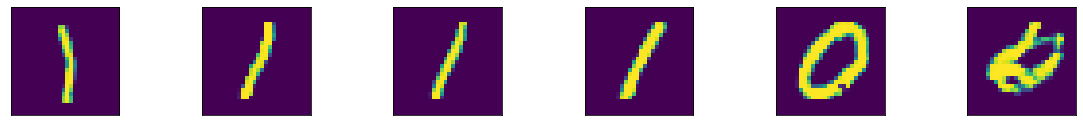

Epoch 189
Loss D: 0.16244487
Loss G: 2.6604767
Epoch 190
Loss D: 0.17633705
Loss G: 2.4538305


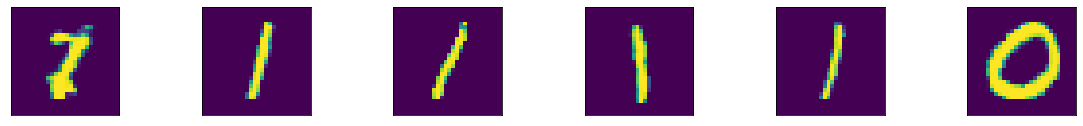

Epoch 191
Loss D: 0.15766099
Loss G: 2.432065
Epoch 192
Loss D: 0.17182314
Loss G: 3.0230954


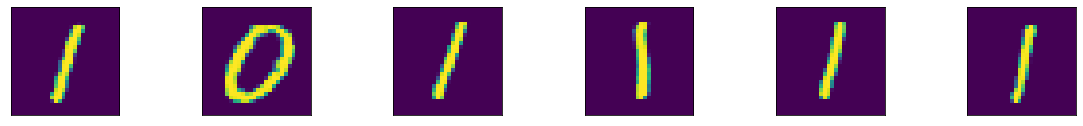

Epoch 193
Loss D: 0.1766549
Loss G: 2.5416758
Epoch 194
Loss D: 0.15882292
Loss G: 2.8831213


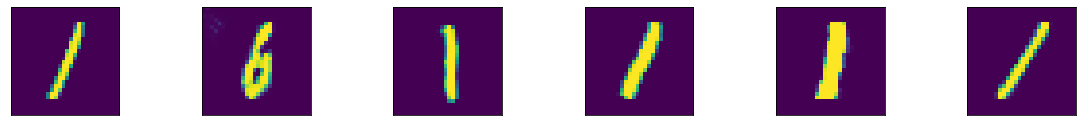

Epoch 195
Loss D: 0.13349642
Loss G: 2.7515554
Epoch 196
Loss D: 0.14855747
Loss G: 2.680457


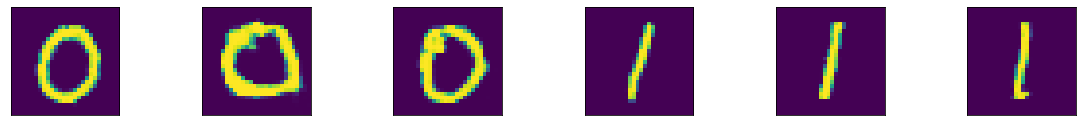

Epoch 197
Loss D: 0.15676367
Loss G: 2.8582895
Epoch 198
Loss D: 0.13825293
Loss G: 3.0009942


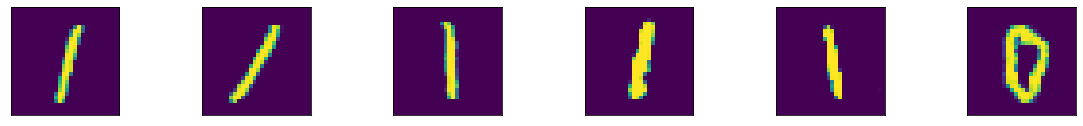

Epoch 199
Loss D: 0.14213312
Loss G: 2.6337204


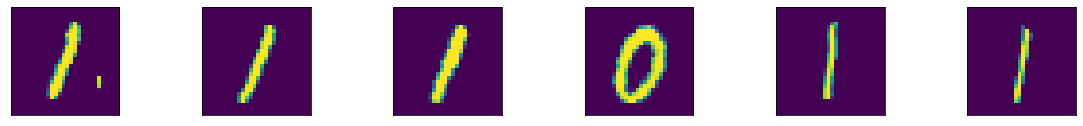

In [6]:
if __name__ == '__main__':
    main()